In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_curve, precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
import scipy.stats as st 
from sklearn.utils import resample
from scipy.stats import wilcoxon


Evaluating SVM:
Cross-validation Accuracy: 0.5714 (std: 0.0204)
Sensitivity (Recall): 0.6167 std: ± 0.0000
Specificity: 0.4744 std: ± 0.0000
F1 Score: 0.3364 std: ± 0.0000
PPV (Precision): 0.2313 std:± 0.0000
Evaluating Random Forest:
Cross-validation Accuracy: 0.8109 (std: 0.0006)
Sensitivity (Recall): 0.0333 std: ± 0.0000
Specificity: 1.0000 std: ± 0.0000
F1 Score: 0.0645 std: ± 0.0000
PPV (Precision): 1.0000 std:± 0.0000
Evaluating XGBoost:
Cross-validation Accuracy: 0.7666 (std: 0.0111)
Sensitivity (Recall): 0.2167 std: ± 0.0000
Specificity: 0.8205 std: ± 0.0000
F1 Score: 0.2261 std: ± 0.0000
PPV (Precision): 0.2364 std:± 0.0000
[LightGBM] [Info] Number of positive: 399, number of negative: 1712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3668
[LightGBM] [Info] Number of dat

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Evaluating Logistic Regression:
Cross-validation Accuracy: 0.5657 (std: 0.0187)
Sensitivity (Recall): 0.7000 std: ± 0.0000
Specificity: 0.5000 std: ± 0.0000
F1 Score: 0.3836 std: ± 0.0000
PPV (Precision): 0.2642 std:± 0.0000


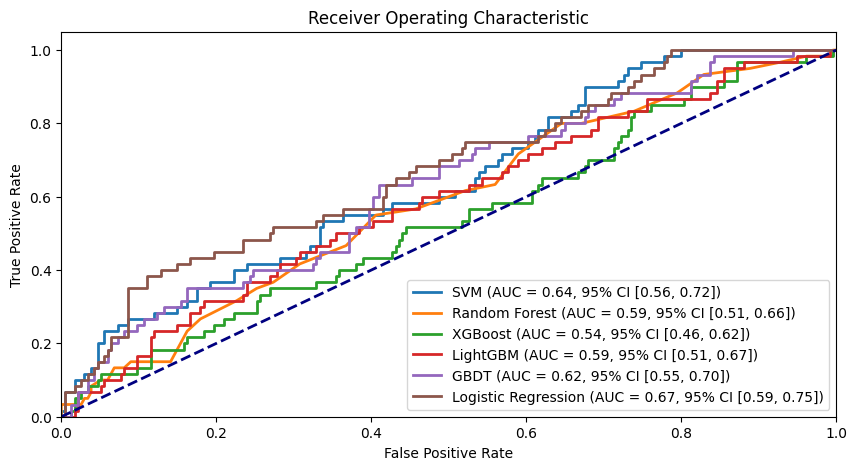

            Classifier  Sensitivity  Specificity  F1 Score  Precision  \
0                  SVM     0.616667     0.474359  0.336364   0.231250   
1        Random Forest     0.033333     1.000000  0.064516   1.000000   
2              XGBoost     0.216667     0.820513  0.226087   0.236364   
3             LightGBM     0.250000     0.833333  0.263158   0.277778   
4                 GBDT     0.066667     0.970085  0.112676   0.363636   
5  Logistic Regression     0.700000     0.500000  0.383562   0.264151   

   AUC Mean  AUC Lower CI  AUC Upper CI  
0  0.642789      0.559069      0.715537  
1  0.586104      0.508465      0.662781  
2  0.538769      0.459270      0.621338  
3  0.589159      0.509038      0.673847  
4  0.624318      0.549586      0.704599  
5  0.672128      0.592227      0.745536  


In [48]:
# Load data
df_transplant = pd.read_csv("features_selected.csv", index_col=0)
feature_names = np.array(df_transplant.iloc[:,:-1].columns)
x = df_transplant.iloc[:,:-1].values
y = df_transplant.iloc[:,-1].values

# Test train split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

# Define class weights (adjust according to the class distribution)
#class_weights = {0: 559/2374 , 1: 2374/559} # Trial 1
class_weights = {0: 2 , 1: 10} # Trial 2


# Initialize models with class weights
svm_classifier = SVC(kernel="linear", class_weight=class_weights, random_state=42)
random_forest = RandomForestClassifier(class_weight=class_weights, random_state=42)
xgb_classifier = XGBClassifier(scale_pos_weight=10, random_state=42)  # XGBoost has a separate parameter for class imbalance
lgbm_classifier = LGBMClassifier(class_weight=class_weights, random_state=42)
gbdt_classifier = GradientBoostingClassifier(random_state=43)
logistic_classifier = LogisticRegression(class_weight=class_weights, random_state=42)

# Update classifiers list and classifier_names accordingly
classifiers = [svm_classifier, random_forest, xgb_classifier, lgbm_classifier, gbdt_classifier, logistic_classifier]
classifier_names = ["SVM", "Random Forest", "XGBoost", "LightGBM", "GBDT", "Logistic Regression"]


# Function to compute AUC with bootstrapped confidence intervals
def compute_auc_with_ci(y_true, y_scores, n_bootstraps=1000, ci=95):
    aucs = []
    for _ in range(n_bootstraps):
        # Bootstrap sample
        y_true_boot, y_scores_boot = resample(y_true, y_scores)
        # Compute AUC
        fpr, tpr, _ = roc_curve(y_true_boot, y_scores_boot)
        auc_score = auc(fpr, tpr)
        aucs.append(auc_score)
    # Compute confidence intervals
    lower_ci = np.percentile(aucs, (100-ci)/2)
    upper_ci = np.percentile(aucs, ci+((100-ci)/2))
    return aucs, np.mean(aucs), lower_ci, upper_ci


# Create lists to store performance metrics
metrics_data = []
predictions = []
plt.figure(figsize=(10, 5))

# Perform 5-fold cross-validation and evaluate models
for clf, clf_name in zip(classifiers, classifier_names):
    # Perform cross-validation
    cv_scores = cross_val_score(clf, x_train, y_train, cv=5, scoring='accuracy')
    print(f"Evaluating {clf_name}:")
    print(f"Cross-validation Accuracy: {np.mean(cv_scores):.4f} (std: {np.std(cv_scores):.4f})")
    
    # Train model
    clf.fit(x_train, y_train)
    
    # Predictions
    y_pred = clf.predict(x_test)

    # Performance metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    spec = confusion_matrix(y_test, y_pred)[0,0] / np.sum(confusion_matrix(y_test, y_pred)[0,:])
    ppv = precision
    
    # Print metrics with confidence intervals
    print(f"Sensitivity (Recall): {recall:.4f}", f"std: \u00B1 {np.std(recall):.4f}")
    print(f"Specificity: {spec:.4f}", f"std: \u00B1 {np.std(spec):.4f}")
    print(f"F1 Score: {f1:.4f}", f"std: \u00B1 {np.std(f1):.4f}")
    print(f"PPV (Precision): {ppv:.4f}", f"std:\u00B1 {np.std(ppv):.4f}")


    if hasattr(clf, "predict_proba"):
        y_scores = clf.predict_proba(x_test)[:, 1]


    else:
        y_scores = clf.decision_function(x_test)
    
    aucs, auc_mean, auc_lower_ci, auc_upper_ci = compute_auc_with_ci(y_test, y_scores)

    predictions.append([clf_name, y_pred, aucs])

    # Append metrics to the list
    metrics_data.append([clf_name, recall, spec, f1, ppv, auc_mean, auc_lower_ci, auc_upper_ci])
    
    
    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{clf_name} (AUC = {auc_mean:.2f}, 95% CI [{auc_lower_ci:.2f}, {auc_upper_ci:.2f}])')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Create a dataframe
metrics_df = pd.DataFrame(metrics_data, columns=['Classifier', 'Sensitivity', 'Specificity', 'F1 Score', 'Precision', 'AUC Mean', 'AUC Lower CI', 'AUC Upper CI'])
print(metrics_df)


# Create a DataFrame for predictions
predictions_df = pd.DataFrame(predictions, columns=['Classifier', 'Probability_Predictions', "AUCs"])



In [49]:
# Perform Wilcoxon signed-rank test for paired prediction probability
for i in range(len(classifier_names)):
    for j in range(i+1, len(classifier_names)):
        clf1_name = classifier_names[i]
        clf2_name = classifier_names[j]
        clf1_probs = predictions_df[predictions_df['Classifier'] == clf1_name]['Probability_Predictions'].values[0]
        clf2_probs = predictions_df[predictions_df['Classifier'] == clf2_name]['Probability_Predictions'].values[0]
        _, p_value = wilcoxon(x=clf1_probs, y=clf2_probs)
        print(f"Wilcoxon signed-rank test p-value for {clf1_name} vs {clf2_name}: {p_value:.4f}")

Wilcoxon signed-rank test p-value for SVM vs Random Forest: 0.0000
Wilcoxon signed-rank test p-value for SVM vs XGBoost: 0.0000
Wilcoxon signed-rank test p-value for SVM vs LightGBM: 0.0000
Wilcoxon signed-rank test p-value for SVM vs GBDT: 0.0000
Wilcoxon signed-rank test p-value for SVM vs Logistic Regression: 0.8273
Wilcoxon signed-rank test p-value for Random Forest vs XGBoost: 0.0000
Wilcoxon signed-rank test p-value for Random Forest vs LightGBM: 0.0000
Wilcoxon signed-rank test p-value for Random Forest vs GBDT: 0.0067
Wilcoxon signed-rank test p-value for Random Forest vs Logistic Regression: 0.0000
Wilcoxon signed-rank test p-value for XGBoost vs LightGBM: 0.8788
Wilcoxon signed-rank test p-value for XGBoost vs GBDT: 0.0000
Wilcoxon signed-rank test p-value for XGBoost vs Logistic Regression: 0.0000
Wilcoxon signed-rank test p-value for LightGBM vs GBDT: 0.0000
Wilcoxon signed-rank test p-value for LightGBM vs Logistic Regression: 0.0000
Wilcoxon signed-rank test p-value for G

In [50]:
# Perform Wilcoxon signed-rank test for paired prediction probability
for i in range(len(classifier_names)):
    for j in range(i+1, len(classifier_names)):
        clf1_name = classifier_names[i]
        clf2_name = classifier_names[j]
        clf1_probs = predictions_df[predictions_df['Classifier'] == clf1_name]['AUCs'].values[0]
        clf2_probs = predictions_df[predictions_df['Classifier'] == clf2_name]['AUCs'].values[0]
        _, p_value = wilcoxon(x=clf1_probs, y=clf2_probs)
        print(f"Wilcoxon signed-rank test p-value for {clf1_name} vs {clf2_name}: {p_value:.4f}")

Wilcoxon signed-rank test p-value for SVM vs Random Forest: 0.0000
Wilcoxon signed-rank test p-value for SVM vs XGBoost: 0.0000
Wilcoxon signed-rank test p-value for SVM vs LightGBM: 0.0000
Wilcoxon signed-rank test p-value for SVM vs GBDT: 0.0000
Wilcoxon signed-rank test p-value for SVM vs Logistic Regression: 0.0000
Wilcoxon signed-rank test p-value for Random Forest vs XGBoost: 0.0000
Wilcoxon signed-rank test p-value for Random Forest vs LightGBM: 0.1066
Wilcoxon signed-rank test p-value for Random Forest vs GBDT: 0.0000
Wilcoxon signed-rank test p-value for Random Forest vs Logistic Regression: 0.0000
Wilcoxon signed-rank test p-value for XGBoost vs LightGBM: 0.0000
Wilcoxon signed-rank test p-value for XGBoost vs GBDT: 0.0000
Wilcoxon signed-rank test p-value for XGBoost vs Logistic Regression: 0.0000
Wilcoxon signed-rank test p-value for LightGBM vs GBDT: 0.0000
Wilcoxon signed-rank test p-value for LightGBM vs Logistic Regression: 0.0000
Wilcoxon signed-rank test p-value for G

In [32]:
# Logistic Regression Coefficient
logistic_coef = logistic_classifier.coef_.ravel()
df_logistic = pd.DataFrame()
df_logistic['feature_names'] = feature_names
df_logistic['feature_imp'] = logistic_coef
df_logistic = df_logistic.sort_values('feature_imp').reset_index(drop=True)
df_logistic.head(-3)

,feature_names,feature_imp
0,CAN_WORK_YES_STAT,-2.845036
1,REC_DR1,-2.112303
2,REC_HGT_CM,-1.701993
3,CAN_FUNCTN_STAT,-1.504419
4,REC_FUNCTN_STAT,-1.210807
...,...,...
58,REC_PROCEDURE_TY_LI,0.874793
59,REC_DGN2,0.941885
60,CAN_MAX_MILE,1.066387
61,dri_1,1.121712


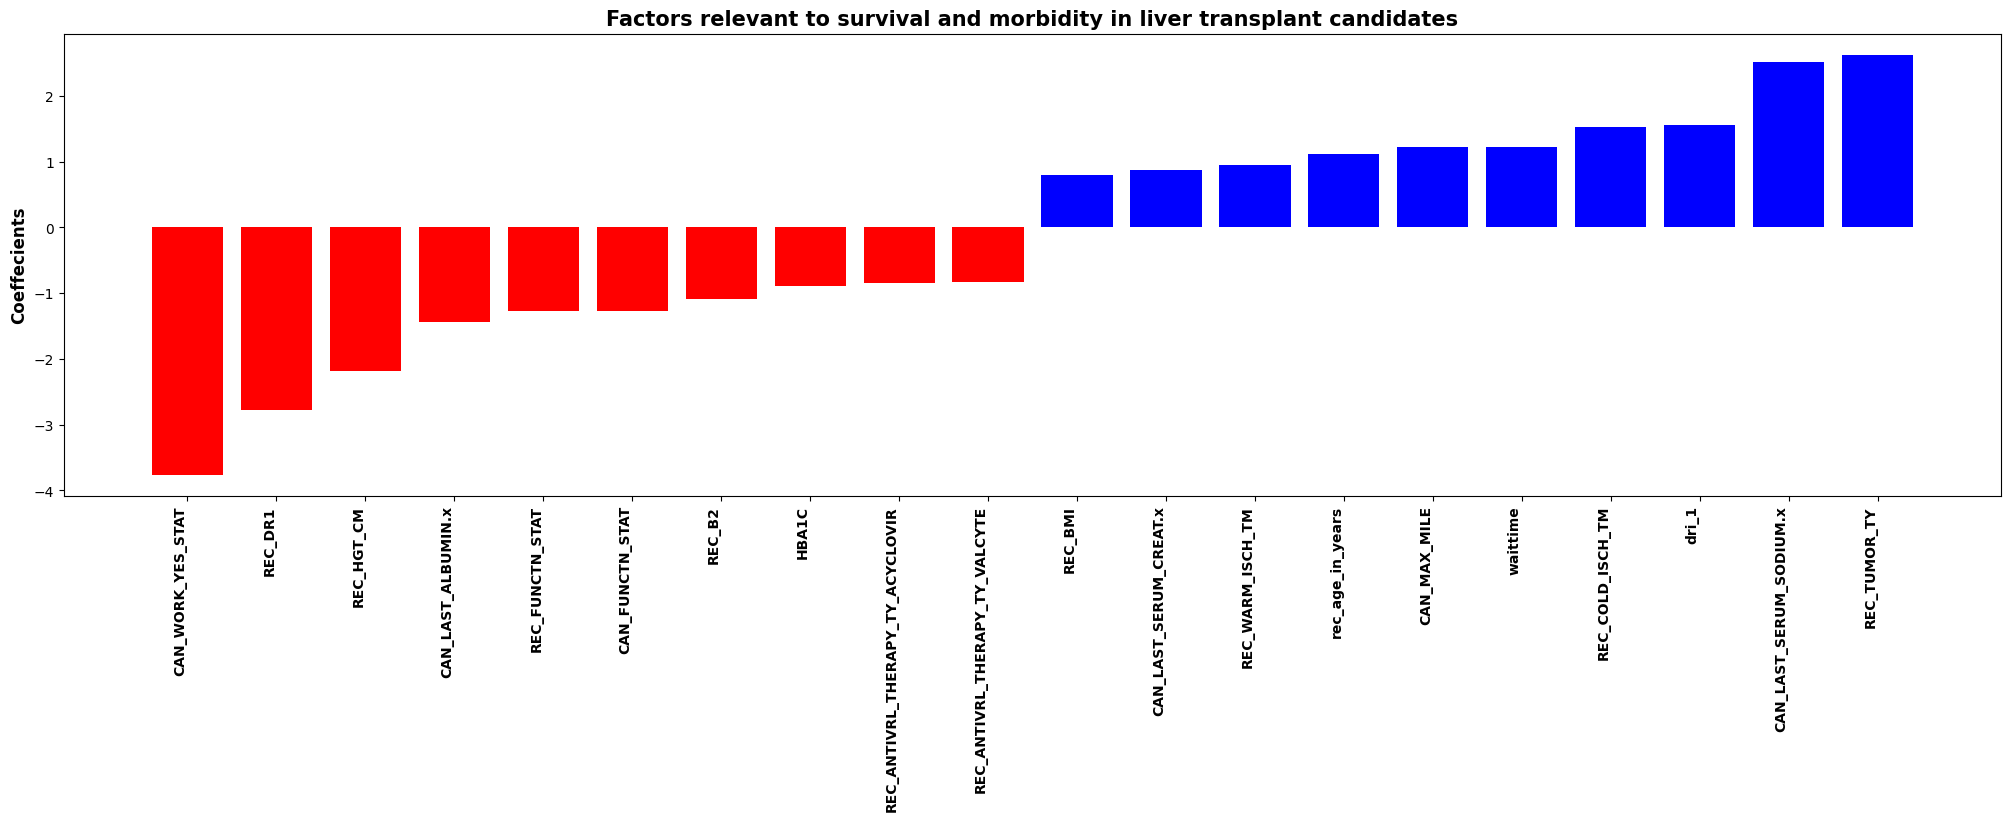

In [4]:
# Coefficient
coef = svm_classifier.coef_.ravel()
df_svm = pd.DataFrame()
df_svm['feature_names'] = feature_names
df_svm['feature_imp'] = coef
df_svm = df_svm.sort_values('feature_imp').reset_index(drop=True)

#Top feature selection
feature_names= df_transplant.iloc[:,:-1].columns
coef = svm_classifier.coef_.ravel()
top_features = 10
top_positive_coefficients = np.argsort(coef)[-top_features:]
top_negative_coefficients = np.argsort(coef)[:top_features]
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])

#Plotting
plt.figure(facecolor="white", figsize=(25,6))
colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
feature_names = np.array(feature_names)
plt.title("Factors relevant to survival and morbidity in liver transplant candidates", fontweight="bold", size=15)
plt.ylabel("Coeffecients", fontweight="bold", size =12)
plt.xticks(np.arange(2 * top_features), feature_names[top_coefficients], rotation="vertical", ha='right', fontweight="bold")



#plt.savefig("top50.png", transparent=False, bbox_inches='tight', dpi=400)
plt.show()